# Predicting Bike Rentals

The University of Porto has collected data about bike rentals in Washington D.C, the original dataset can be found [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). <br>
Each row in the dataset shows data about the total number of bike rentals for an hour of the day along with data about the season, the weather, the temperature and so on. <br>
I'll use the data to train a different machine learning models ( a linear regression, a decision tree and a random forest) and predict bike the number of bike rentals.

Here are the descriptions for the relevant columns:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import math
%matplotlib inline


In [55]:
bike_rentals = pd.read_csv("bike_rental_hour.csv",parse_dates = ["dteday"])

In [56]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [57]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

### Number of Bike Rentals

Let's look at how the number of bike rentals are distributed.

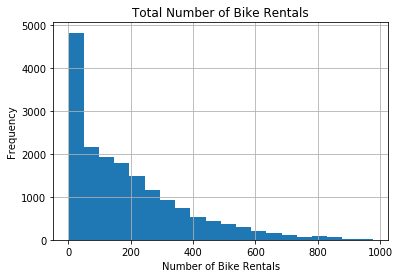

In [58]:
bike_rentals["cnt"].hist(bins=20)
plt.title("Total Number of Bike Rentals")
plt.xlabel("Number of Bike Rentals")
plt.ylabel("Frequency")
plt.show()

It seems most of the rows in the dataset have less than 250 bike rentals per hour, with a peek for less than 50, so in many cases there is a limited number of bike rentals. The dataset is skewed to the right, so only a minority of rows have a very high number of biker rentals, over 500 up to 1000 bike rentals per hour.

### Features Correlations

I'm trying to predict the number of bike rentals, so let'see which features are more correlated to the "cnt" column.

In [59]:
bike_corr = bike_rentals.corr()["cnt"].sort_values()
bike_corr

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [60]:
bike_corr[abs(bike_corr) > 0.3]

hum          -0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [61]:
print(bike_rentals[["temp", "atemp"]].corr())

           temp     atemp
temp   1.000000  0.987672
atemp  0.987672  1.000000


The columns casual and registered are highly correlated to cnt because cnt is calculated summying these two values, so we can't use them for predicting cnt, other columns aren't correlated because they are categories rather than real numerical values, such as weekday, workingday, and so on.<br>
The promising real numeric columns are hum and temp. I'll remove the column atemp, the normalized temperature because temp and atemp are strongly correlated, so keeping both could result in collinearity and a less performant model.

### Calculating Features

The hr column, describing the hour of the day the rental takes place,  is related to the number of bike rentals, the correlation coefficient is about 0.39. Some hours or the day can be grouped togheter to spot patterns, like morning, afternoon, evening and night rentals. <br>

I'll divide the hours of the day according to the following codes: <br>
<ul>
<li>1 if the hour is between 6 and 12 </li>
<li> 2 if the hour is between 12 and 18  </li>
<li> 3 if the hour is between 18 an 24</li>
<li> 4 if th hour is between 0 and 6</li>
</ul>

In [62]:
def assign_label(hour):
    code = 0
    if hour >= 6 and hour < 12:
        code = 1
    elif hour >= 12 and hour < 18:
        code = 2
    elif hour >= 18 and hour< 24:
        code = 3
    elif hour >= 0 and hour < 6:
        code = 4
        
    return code

In [63]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [64]:
bike_rentals["time_label"].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

The bike rentals seem to be equally splitted in all the four time labels.

### Scaling and Transforming Features for Linear Regression

In order to use linear regression, data should be scaled, otherwise columns with range of values larger than other columns would be considered more when fitting the model. <br>
Other data are expressed as numerical, but they are indeed categorical, such time_label or weathersit, I'll transform them using pd.get_dummies(), dropping then one column for every feature converted, in order to avoid collinearity.

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
numeric_cols = ["temp", "hum", "windspeed"]

In [67]:
scaler = MinMaxScaler()

In [68]:
scaler.fit(bike_rentals[numeric_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [69]:
numeric_copy = bike_rentals[numeric_cols].copy()

In [70]:
numeric_copy[numeric_cols] = scaler.transform(numeric_copy[numeric_cols])

In [71]:
numeric_copy.head()

,temp,hum,windspeed
0,0.224490,0.81,0.0
1,0.204082,0.80,0.0
2,0.204082,0.80,0.0
3,0.224490,0.75,0.0
4,0.224490,0.75,0.0


In [72]:
dummy_cols = ["season", "mnth", "hr", "holiday", "workingday", "weathersit", "time_label"]

In [73]:
dummy_df = bike_rentals[dummy_cols].copy()

In [74]:
for col in dummy_cols:
    dummies = pd.get_dummies(dummy_df[col], prefix=col)
    columns = dummies.columns
    dummies_reduced = dummies.iloc[:, 0: len(columns) - 1]
    dummy_df = pd.concat([dummy_df, dummies_reduced], axis =1)

In [75]:
dummy_df = dummy_df.drop(dummy_cols, axis=1)

In [76]:
scaled_df = pd.concat([numeric_copy, dummy_df], axis=1)

In [77]:
scaled_df.head(2)

,temp,hum,windspeed,season_1,season_2,season_3,mnth_1,mnth_2,mnth_3,mnth_4,...,hr_21,hr_22,holiday_0,workingday_0,weathersit_1,weathersit_2,weathersit_3,time_label_1,time_label_2,time_label_3
0,0.224490,0.81,0.0,1,0,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0
1,0.204082,0.80,0.0,1,0,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


### Splitting Data into Train and Test Set

I'll now split the dataset in train and test set. The training dataset will be 80% of all the data, the remaining 20% will be the test set.

In [78]:
target = bike_rentals["cnt"]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target,
                                                    test_size=0.20,
                                                    random_state=1)

### Applying Linear Regression

I'll now apply Lineare Regression using the LinearRegression class from scikit-learn to the data selected above.

In [80]:
bike_rentals["cnt"].mean()

189.46308763450142

In [81]:
lr = LinearRegression()

In [82]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(lr_rmse)

111.79881062323602


The root mean squared error for Linear Regression is quite high, it is about 112 when the average bike rentals is about 189, so Lineare Regression doesn't seem to fit this data very well.

### Applying a Decision Tree

Decision Trees don't benefit very much from scaling numeric variable or one-hot encoding for categorical variables, one-hot encoding can even be worsen the algorithm, so numeric encoding works best for Decision Trees. Our dataset is already numeric encoded for categorical variables so I'll create new train and test set for the DecisionTreeRegressor and RandomForestRegressor classes.

In [83]:
min_samples_leaf = [5,10, 20, 30]

In [84]:
columns = ["atemp","temp","hum", "windspeed","season",
           "mnth", "hr", "holiday", "workingday", "weathersit", "time_label"]

In [85]:
rentals = bike_rentals[columns].copy()

In [86]:
target = bike_rentals["cnt"]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(rentals,
                                                    target,test_size=0.20,
                                                    random_state=1)

In [88]:
min_samples_leaf = [5, 10, 15, 18, 20, 30]

In [89]:
rmses =[]

In [90]:
for msl in min_samples_leaf:
    dtr = DecisionTreeRegressor(min_samples_leaf = msl, random_state=1)
    dtr.fit(X_train, y_train)
    predictions = dtr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmses.append(rmse)

In [91]:
rmses

[80.6341632598047,
 78.5567961087501,
 77.07551838035369,
 77.90551204899887,
 77.12498607354611,
 78.43137928214384]

In [92]:
print(min_samples_leaf[np.argmin(rmses)])
print(np.min(rmses))

15
77.07551838035369


In [93]:
((111.8 - 77.1) /111.8) * 100

31.037567084078717

Using a decision tree improved the root mean squared error of about 31%, let's see if this result lasts with cross validation.

### Cross Validation with Decision Trees

In [94]:
from sklearn.model_selection import cross_val_score, KFold

In [95]:
num_folds = [3, 5, 10]
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = DecisionTreeRegressor(min_samples_leaf=15, random_state=1 )
    mses = cross_val_score(model, rentals, target, scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  78.59600579394562 std RMSE:  0.5250854464124532
5 folds:  avg RMSE:  77.55080428043311 std RMSE:  1.4709113401531893
10 folds:  avg RMSE:  76.76231066999006 std RMSE:  2.6508322559488082


The cross validation of the model confirms the improvement.

### Applying Random Forests

In [96]:
min_samples_leaf = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60]

In [97]:
rmses = []

In [98]:
for num in min_samples_leaf:
    rfr = RandomForestRegressor(min_samples_leaf=num, random_state = 1)
    rfr.fit(X_train, y_train)
    predictions = rfr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmses.append(rmse)

C:\Users\Tundra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tundra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tundra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tundra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tundra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

In [99]:
print(min_samples_leaf[np.argmin(rmses)])
print(np.min(rmses))

3
70.86714732486068


In [100]:
n_estimators = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

In [101]:
rmses = []

In [102]:
for num in n_estimators:
    rfr = RandomForestRegressor(n_estimators = num,
                                min_samples_leaf=3, random_state = 1)
    rfr.fit(X_train, y_train)
    predictions = rfr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmses.append(rmse)

In [103]:
rmses

[73.81456833769995,
 70.86714732486068,
 70.45868484853868,
 70.14180433500715,
 70.10495535605834,
 69.8068813795146,
 69.85555775498835,
 69.83658193550828,
 69.62652179494701,
 69.5354480199492,
 69.53266330008097,
 69.15383856684963]

In [104]:
print(n_estimators[np.argmin(rmses)])
print(np.min(rmses))

100
69.15383856684963


With RandomForest the accuracy has slightly improved, respect to the Decision Tree.

### Cross Validation with Random Forests

Let's see if the improvement using Random Forest is solid or it depends on the split.

In [105]:
num_folds = [3, 5, 10]

In [106]:
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = RandomForestRegressor(n_estimators = 100,min_samples_leaf=3, random_state=1 )
    mses = cross_val_score(model, rentals, target, scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  70.05786237333574 std RMSE:  0.8703877171782539
5 folds:  avg RMSE:  68.81896993956079 std RMSE:  1.0498459993092537
10 folds:  avg RMSE:  68.86953037540312 std RMSE:  1.9705417500024316


The cross valiation of the Random Forest model confirms the improvement of the Random Forest model.